# Dataloader

In [3]:
import numpy as np
import h5py
mat_data = h5py.File("hcp1003_RestALL_Schaefer_tcCLEAN.mat", "r")

In [4]:
key_name = "FCmats"  # Replace with actual variable name
print(mat_data[key_name])  # Print entire variable (if small)
# print(mat_data[key_name][0])  # Print first 5 elements (if large)
FC_mats = mat_data[key_name]
print(FC_mats.shape)

<HDF5 dataset "FCmats": shape (92, 92, 4, 1001), type "<f8">
(92, 92, 4, 1001)


In [5]:
key_name = "tc_clean"  # Replace with actual variable name
print(mat_data[key_name])  # Print entire variable (if small)
#print(mat_data[key_name][:1])  # Print first 5 elements (if large)

# Select the variable
tc_clean = mat_data[key_name]

# Check shape and type
print(f"Shape: {tc_clean.shape}, Type: {tc_clean.dtype}")

# Check the first reference
first_ref = tc_clean[0, 0]  # Access first HDF5 object reference
print("First reference type:", type(first_ref))

# If it's an object reference, get its name in the HDF5 file
if isinstance(first_ref, h5py.Reference):
    obj = mat_data[first_ref]  # Dereference
    print("Dereferenced object type:", type(obj))
    print("Shape of the object:", obj.shape)
    # print("First few values:", obj[:5])  # Print actual data

num_sessions, num_subjects =  tc_clean.shape
ts_data = [[np.array(mat_data[ref]) for ref in tc_clean[i]] for i in range(num_sessions)]
ts_data = np.transpose(ts_data, (1, 0, 2, 3)) # --> [subjects, sessions, regions, timepoints]
print("Shape of the ts_data:", np.array(ts_data).shape)

<HDF5 dataset "tc_clean": shape (4, 1003), type "|O">
Shape: (4, 1003), Type: object
First reference type: <class 'h5py.h5r.Reference'>
Dereferenced object type: <class 'h5py._hl.dataset.Dataset'>
Shape of the object: (92, 1200)
Shape of the ts_data: (1003, 4, 92, 1200)


## BOLD time series

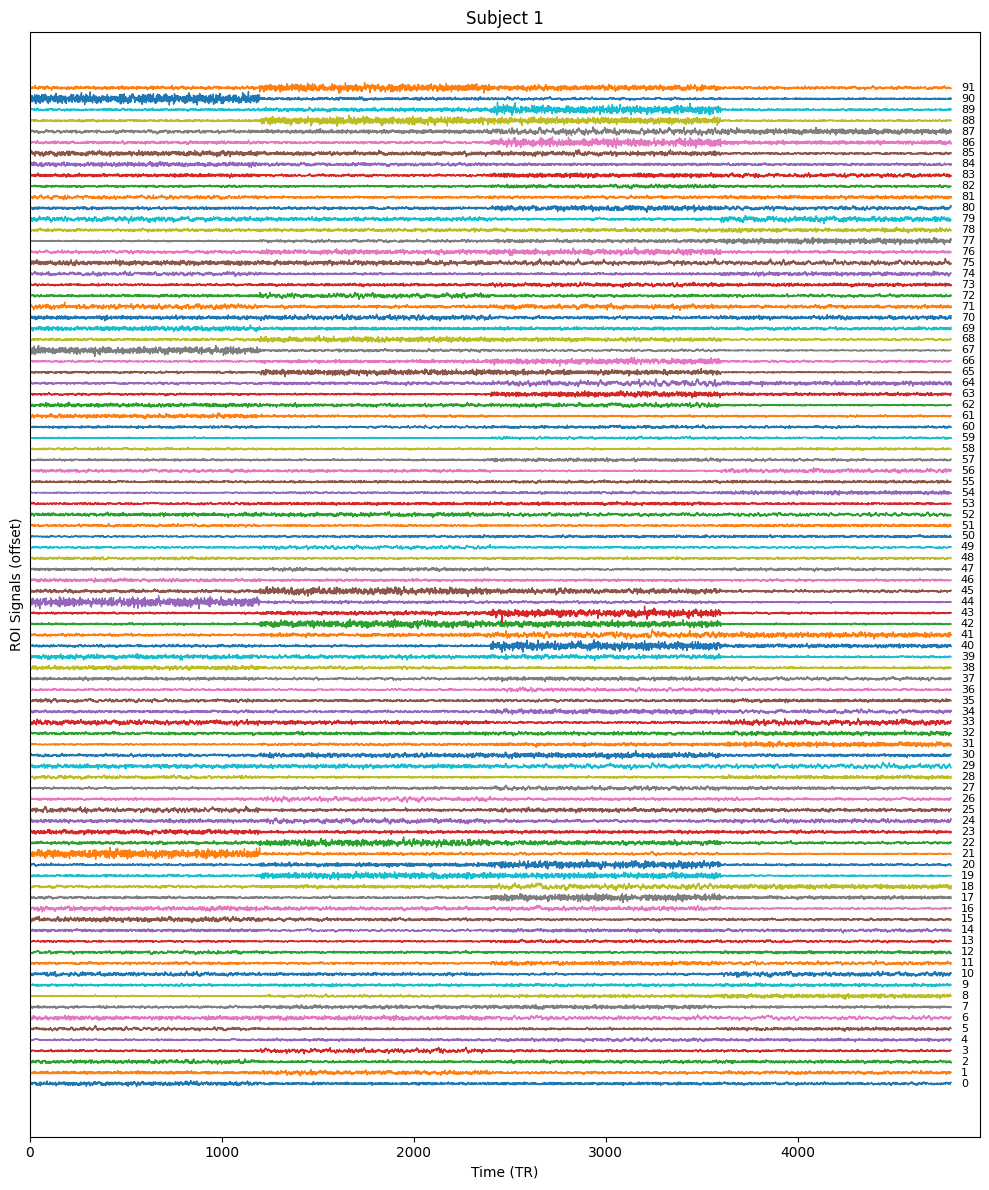

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=[10, 12], dpi=100)

sub_id = 0  
reshaped_data = ts_data[sub_id].reshape(92, 1200 * 4).T  # [4800, 92]

offset = 0
offset_step = 10
signal_length = reshaped_data.shape[0]

for roi_id in range(92):
    signal = reshaped_data[:, roi_id]
    shifted_signal = signal + offset

    plt.plot(shifted_signal, linewidth=1)

    plt.text(signal_length + 50, offset, f'{roi_id}', va='center', fontsize=8)

    offset += offset_step

plt.title(f'Subject {sub_id + 1}')
plt.xlabel('Time (TR)')
plt.ylabel('ROI Signals (offset)')
plt.yticks([])
plt.grid(False)
plt.xlim([0, signal_length + 150])
plt.tight_layout()
plt.show()


## temporal weighted graph

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def compute_temporal_graphs(ts_data, subject_idx=0, selected_sessions=[0], window_size=100, step_size=10):
    """
    Generate temporal graphs using a sliding window approach for selected sessions.

    Parameters:
    ts_data : ndarray
        Time series data of shape [subjects, sessions, regions, timepoints].
    subject_idx : int
        Index of the subject to process.
    selected_sessions : list
        List of session indices to include in analysis.
    window_size : int
        Size of the sliding window.
    step_size : int
        Step size for the sliding window.

    Returns:
    graphs : list
        List of NetworkX graphs representing functional connectivity over time.
    FC_mats : ndarray
        Functional connectivity matrices for visualization.
    """
    subject_data = ts_data[subject_idx]  # Shape: [sessions, regions, timepoints]

    # Concatenate only the selected session timepoints
    combined_timepoints = np.concatenate([subject_data[s] for s in selected_sessions], axis=1)  # Shape: [regions, selected_timepoints]
    total_timepoints = combined_timepoints.shape[1]

    # Normalize time series to avoid zero correlation issues
    combined_timepoints = (combined_timepoints - np.mean(combined_timepoints, axis=1, keepdims=True)) / np.std(combined_timepoints, axis=1, keepdims=True)

    # Compute the correct number of graphs
    num_graphs = (total_timepoints - window_size) // step_size + 1
    FC_mats = np.zeros((combined_timepoints.shape[0], combined_timepoints.shape[0], num_graphs))

    graphs = []
    graph_idx = 0
    for start in range(0, total_timepoints - window_size + 1, step_size):
        window = combined_timepoints[:, start:start + window_size]  # Shape: [regions, window_size]

        # Compute functional connectivity (Pearson correlation) correctly
        corr_matrix = np.corrcoef(window, rowvar=True)  # Correlation across regions
        np.fill_diagonal(corr_matrix, 0)  # Remove self-connections

        FC_mats[:, :, graph_idx] = corr_matrix  # Store at correct index

        # Create a graph
        G = nx.from_numpy_array(corr_matrix)
        graphs.append(G)

        graph_idx += 1

    return graphs, FC_mats

def visualize_fc_matrices(FC_mats, SS):
    """Visualize functional connectivity matrices for selected timepoints with adjusted color bar length."""
    plt.figure(figsize=(12, 6))
    num_plots = len(SS)
    for s, timepoint in enumerate(SS):
        ax = plt.subplot(1, num_plots, s + 1)
        im = ax.imshow(FC_mats[:, :, timepoint], cmap='jet', vmin=-1, vmax=1)
        ax.set_title(f'Timepoint {timepoint}')

        # Adjust color bar to match graph size
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.show()

selected_sessions = [0]  # Select only session 1
temporal_graphs, FC_mats = compute_temporal_graphs(ts_data, subject_idx=2, selected_sessions=selected_sessions, window_size=100, step_size=10)

In [9]:
print(len(temporal_graphs), type(temporal_graphs), type(FC_mats))

111 <class 'list'> <class 'numpy.ndarray'>


In [10]:
print(np.array(temporal_graphs).shape)
print(FC_mats.shape)

(111, 92)
(92, 92, 111)


In [21]:
weighted_graph = np.transpose(FC_mats,(2, 0, 1))
print(weighted_graph.shape)

(111, 92, 92)


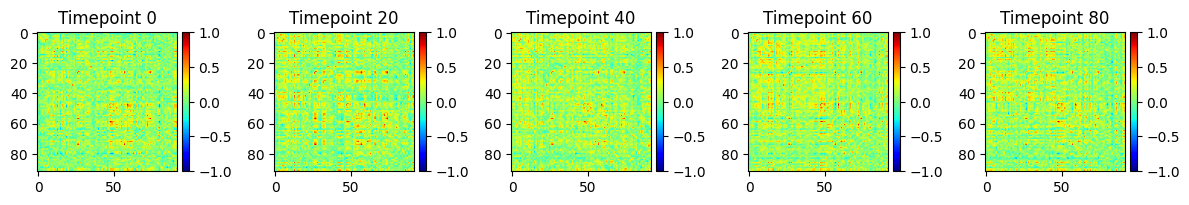

In [212]:
SS = [0, 20, 40, 60, 80]
visualize_fc_matrices(FC_mats, SS)

## binary graph

In [23]:
import numpy as np
import networkx as nx

def compute_binary_temporal_graphs(FC_mats, threshold=0.1):
    """
    Compute binary adjacency matrices from functional connectivity matrices.

    Parameters:
    FC_mats : ndarray
        Functional connectivity matrices over time (shape: [regions, regions, timepoints]).
    threshold : float
        Threshold to binarize the correlation matrix.

    Returns:
    binary_matrices : list
        List of binary adjacency matrices (numpy arrays) over time.
    """
    binary_matrices = []

    for i in range(FC_mats.shape[2]):  # Iterate over time points
        correlation_matrix = FC_mats[:, :, i]

        # Convert to binary adjacency matrix using the threshold
        binary_matrix = (np.abs(correlation_matrix) > threshold).astype(int)

        # Store binary matrix
        binary_matrices.append(binary_matrix)

    return np.array(binary_matrices)

binary_temporal_graphs = compute_binary_temporal_graphs(FC_mats, threshold=0.4)
binary_temporal_graphs[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], shape=(92, 92))

In [24]:
binary_temporal_graphs_len = len(binary_temporal_graphs)
print(len(binary_temporal_graphs), binary_temporal_graphs.shape)

111 (111, 92, 92)


## TEA plot

### original TEA

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_tea_plot(dynfc_matrices_list, session_idx, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (threshold, dynfc_matrices) in enumerate(zip(thresholds, dynfc_matrices_list)):
        row, col = divmod(idx, 2)
        graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

        repeated_edges = [0]
        new_graph = nx.Graph()
        for i in range(1, len(graph_list)):
            new_graph = nx.compose(new_graph, graph_list[i-1])
            repeated_edges.append(nx.intersection(new_graph, graph_list[i]).number_of_edges())

        num_edges = [np.count_nonzero(matrix) // 2 for matrix in dynfc_matrices]
        new_edges = [num_edges[i] - repeated_edges[i] for i in range(len(num_edges))]
        # new_edge_ratios = [new_edges[i] / num_edges[i] if num_edges[i] > 0 else 0 for i in range(len(num_edges))]

        repeated_edges[0] = 0
        new_edges[0] = num_edges[0]
        
        ax1 = axes[row, col]
        x_vals = np.arange(len(repeated_edges))
        ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
        ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.legend(loc='upper left', fontsize=10)
        ax1.set_title(f'Threshold: {threshold}', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
    
    
    plt.tight_layout()
    plt.show()

### TEA with noise

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_tea_plot_th(dynfc_matrices, session_idx, min_v):
    graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

    repeated_edges = [0]  
    new_edges = [len(graph_list[0].edges)]  
    new_edge_ratios = [1.0]  

    prev_graph = nx.Graph()  

    for i in range(len(graph_list)):
        current_graph = graph_list[i]

        repeated_count = 0
        for u, v, weight in current_graph.edges(data=True):
            if prev_graph.has_edge(u, v):
                prev_weight = prev_graph[u][v]['weight']
                if abs(weight['weight'] - prev_weight) <= min_v:
                    repeated_count += 1

        repeated_edges.append(repeated_count)
        new_count = len(current_graph.edges) - repeated_count
        new_edges.append(new_count)
        
        total_edges = len(current_graph.edges)
        new_edge_ratios.append(new_count / total_edges if total_edges > 0 else 0)

        prev_graph = current_graph

    x_vals = np.arange(len(repeated_edges))
    
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
    ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('Number of Edges', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left', fontsize=14)
    ax1.set_title(f'Temporal Edge Analysis Over Time (Session {session_idx + 1})', fontsize=18)
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    ax2.plot(x_vals, new_edge_ratios, color='black', marker='o', linestyle='-', linewidth=2, markersize=6, label="New Edge Ratio")
    ax2.set_ylabel('Proportion of New Edges', fontsize=16, color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right', fontsize=14)
    
    plt.show()

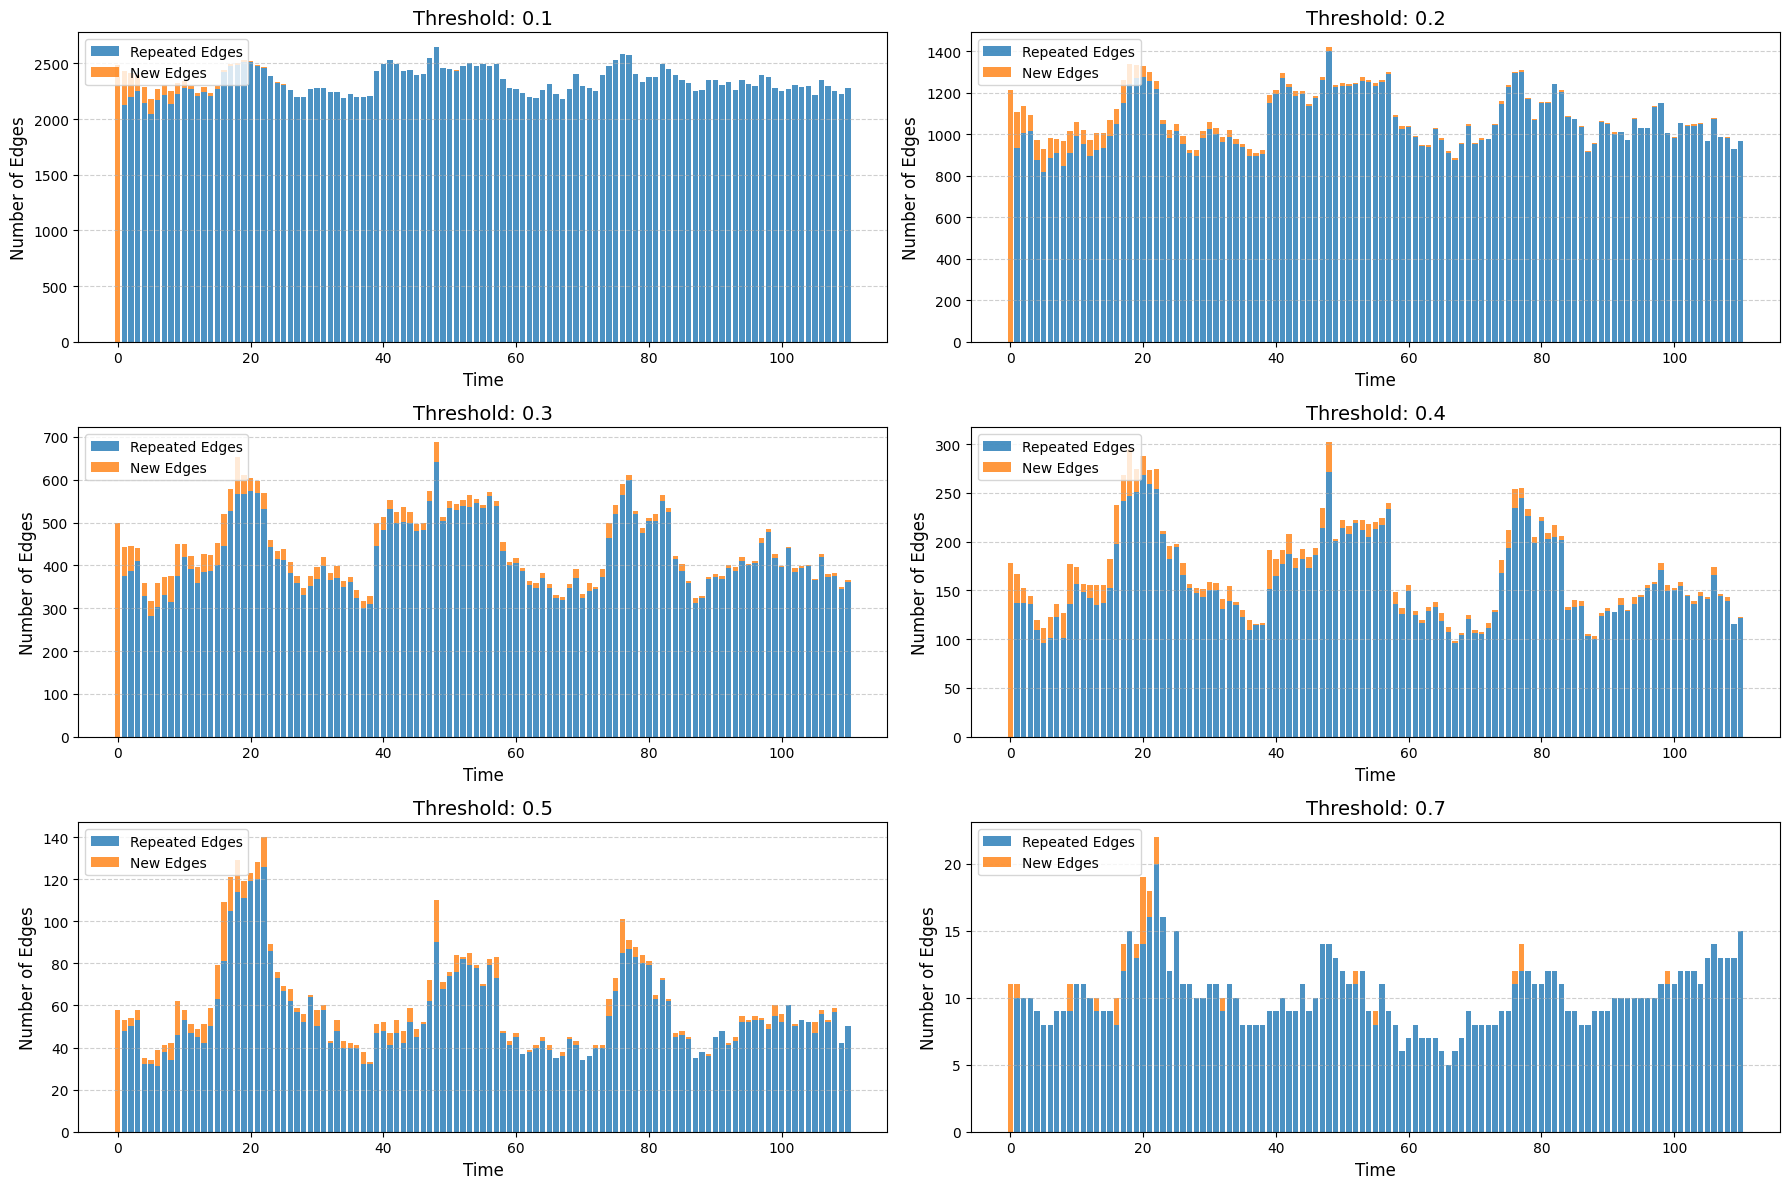

In [141]:
thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)
# change more in the beginning in threshold 0.2, more regione become connected

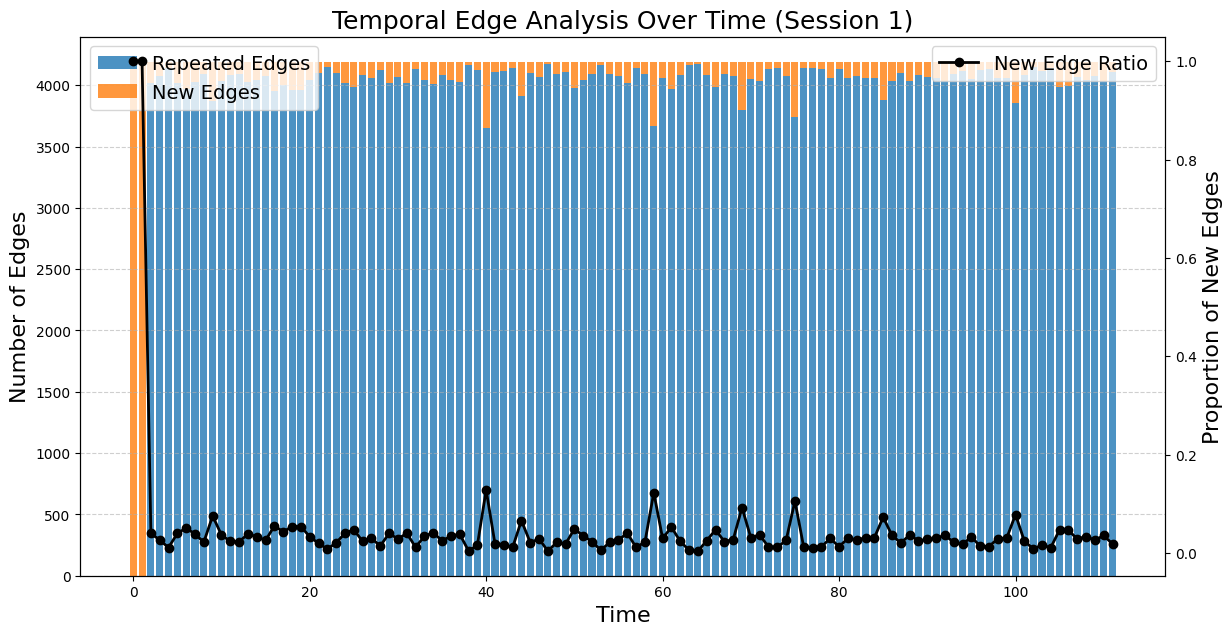

In [144]:
plot_tea_plot_th(weighted_graph, 0, 0.12)
# showing when the brain will change more, filter the noise that under the threshold.

### TEA with novelty

In [26]:
import numpy as np
import networkx as nx

# Function to compute novelty index for a single session
def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()

    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)

        if total_edges > 0:
            novelty_index = len(new_edges) / total_edges
        else:
            novelty_index = 0

        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)

    # Calculate average novelty index for the session
    average_novelty_index = np.mean(novelty_indices)
    return novelty_indices, average_novelty_index

# Compute novelty index for each session and the average novelty index
novelty_indices_per_session = []
average_novelty_indices = []

session_dynfc_matrices = binary_temporal_graphs
novelty_indices, average_novelty_index = compute_novelty_index(session_dynfc_matrices)

novelty_indices_per_session.append(novelty_indices)
average_novelty_indices.append(average_novelty_index)

# Print results for the current session
print(f"Session {0 + 1}:")
print(f"Novelty Indices: {novelty_indices}")
print(f"Average Novelty Index: {average_novelty_index}\n")

# Print average novelty indices for all sessions
print("Average Novelty Index for Each Session:")
print(average_novelty_indices)


Session 1:
Novelty Indices: [1.0, 0.17964071856287425, 0.09868421052631579, 0.05555555555555555, 0.09166666666666666, 0.13513513513513514, 0.17886178861788618, 0.09558823529411764, 0.2047244094488189, 0.23163841807909605, 0.09770114942528736, 0.05732484076433121, 0.08974358974358974, 0.1346153846153846, 0.11612903225806452, 0.16483516483516483, 0.16455696202531644, 0.09701492537313433, 0.16271186440677965, 0.08394160583941605, 0.06944444444444445, 0.05128205128205128, 0.072992700729927, 0.014218009478672985, 0.06666666666666667, 0.020202020202020204, 0.06741573033707865, 0.03184713375796178, 0.03289473684210526, 0.052980132450331126, 0.05660377358490566, 0.05063291139240506, 0.07092198581560284, 0.09740259740259741, 0.021739130434782608, 0.05384615384615385, 0.09166666666666666, 0.017241379310344827, 0.02564102564102564, 0.2094240837696335, 0.09340659340659341, 0.07329842931937172, 0.10096153846153846, 0.0546448087431694, 0.052083333333333336, 0.059782608695652176, 0.03626943005181347,

In [27]:
for i in range(len(novelty_indices)):
    if novelty_indices[i] > 0.2:
        print(i, " ")

0  
8  
9  
39  


#### adaptive lookback

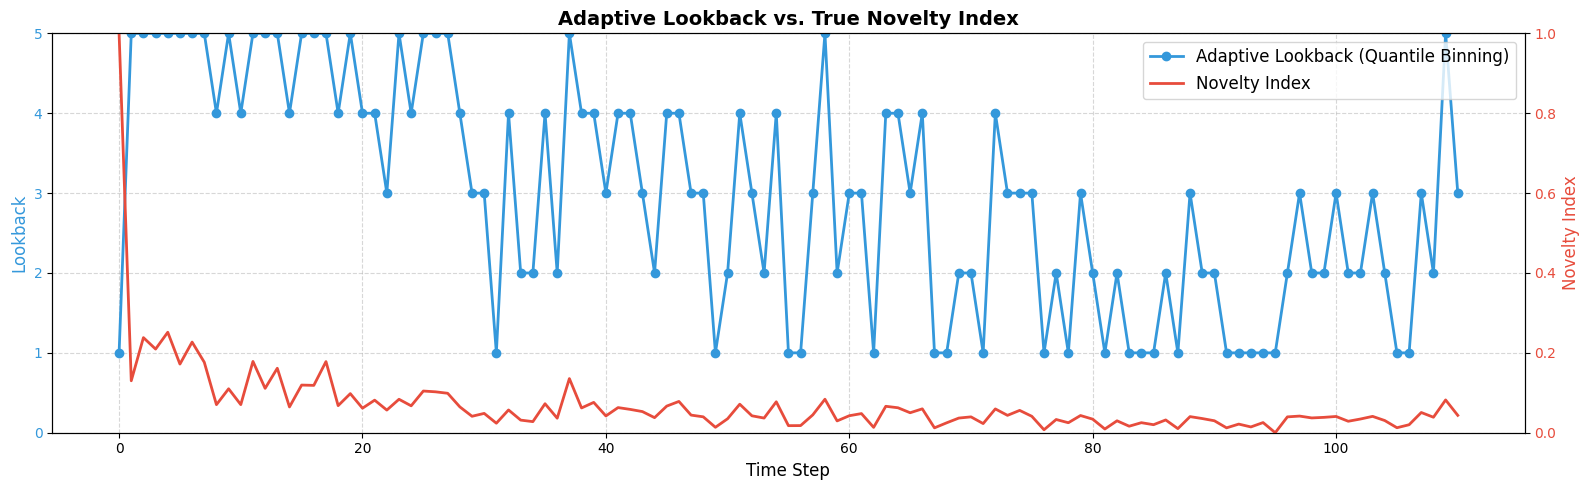

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Ignore the first value
novelty_indices_wo_first = novelty_indices[1:]

# Quantile binning function
def quantile_binning(novelties, min_lookback=1, max_lookback=5):
    novelties = np.array(novelties)
    num_bins = max_lookback - min_lookback + 1
    quantiles = np.quantile(novelties, np.linspace(0, 1, num_bins + 1))

    lookbacks = []
    for n in novelties:
        for i in range(num_bins):
            if quantiles[i] <= n <= quantiles[i + 1]:
                lookbacks.append(min_lookback + i)
                break
    return lookbacks

# Recompute lookbacks
adaptive_lookbacks_wo_first = quantile_binning(novelty_indices_wo_first)
adaptive_lookbacks = [1] + adaptive_lookbacks_wo_first


# Plot using original (unsmoothed) novelty values
fig, ax1 = plt.subplots(figsize=(16, 5))

# Left y-axis: Lookback
ax1.set_xlabel("Time Step", fontsize=12)
ax1.set_ylabel("Lookback", fontsize=12, color="#3498DB")
ax1.plot(adaptive_lookbacks, label="Adaptive Lookback (Quantile Binning)", color="#3498DB", marker="o", linewidth=2)
ax1.tick_params(axis='y', labelcolor="#3498DB")
ax1.set_ylim(0, 5)

# Right y-axis: true novelty values scaled to match visual range
ax2 = ax1.twinx()
ax2.set_ylabel("Novelty Index", fontsize=12, color="#E74C3C")
ax2.plot(np.array(novelty_indices) * 5, label="Novelty Index", color="#E74C3C", linewidth=2)
ax2.set_ylim(0, 5)
ax2_ticks = np.linspace(0, 5, 6)
ax2.set_yticks(ax2_ticks)
ax2.set_yticklabels([f"{tick / 5:.1f}" for tick in ax2_ticks])
ax2.tick_params(axis='y', labelcolor="#E74C3C")

# Title and grid
plt.title("Adaptive Lookback vs. True Novelty Index", fontsize=14, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()


#### plotting with novelty

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.interpolate import make_interp_spline

def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()

    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)

        novelty_index = len(new_edges) / total_edges if total_edges > 0 else 0
        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)

    average_novelty_index = np.mean(novelty_indices) if novelty_indices else 0

    return novelty_indices, average_novelty_index

def plot_tea_plot(dynfc_matrices_list, session_idx, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (threshold, dynfc_matrices) in enumerate(zip(thresholds, dynfc_matrices_list)):
        row, col = divmod(idx, 2)
        graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

        repeated_edges = [0]
        new_graph = nx.Graph()
        for i in range(1, len(graph_list)):
            new_graph = nx.compose(new_graph, graph_list[i-1])
            repeated_edges.append(nx.intersection(new_graph, graph_list[i]).number_of_edges())

        num_edges = [np.count_nonzero(matrix) // 2 for matrix in dynfc_matrices]
        new_edges = [num_edges[i] - repeated_edges[i] for i in range(len(num_edges))]
        novelty_indices, average_novelty_index = compute_novelty_index(dynfc_matrices)

        repeated_edges[0] = 0
        new_edges[0] = num_edges[0]

        ax1 = axes[row, col]
        x_vals = np.arange(len(repeated_edges))
        ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
        ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.legend(loc='upper left', fontsize=10)
        ax1.set_title(f'Threshold: {threshold} (Avg. Novelty: {average_novelty_index:.2f})', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
        
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 10))
        
        # Smoothing the novelty index curve with a thinner red color
        if len(x_vals) > 1:
            x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)
            novelty_smooth = make_interp_spline(x_vals, novelty_indices, k=3)(x_smooth)
            ax3.plot(x_smooth, novelty_smooth, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        else:
            ax3.plot(x_vals, novelty_indices, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        
        ax3.set_ylabel('Novelty Index', fontsize=12, color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        ax3.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()


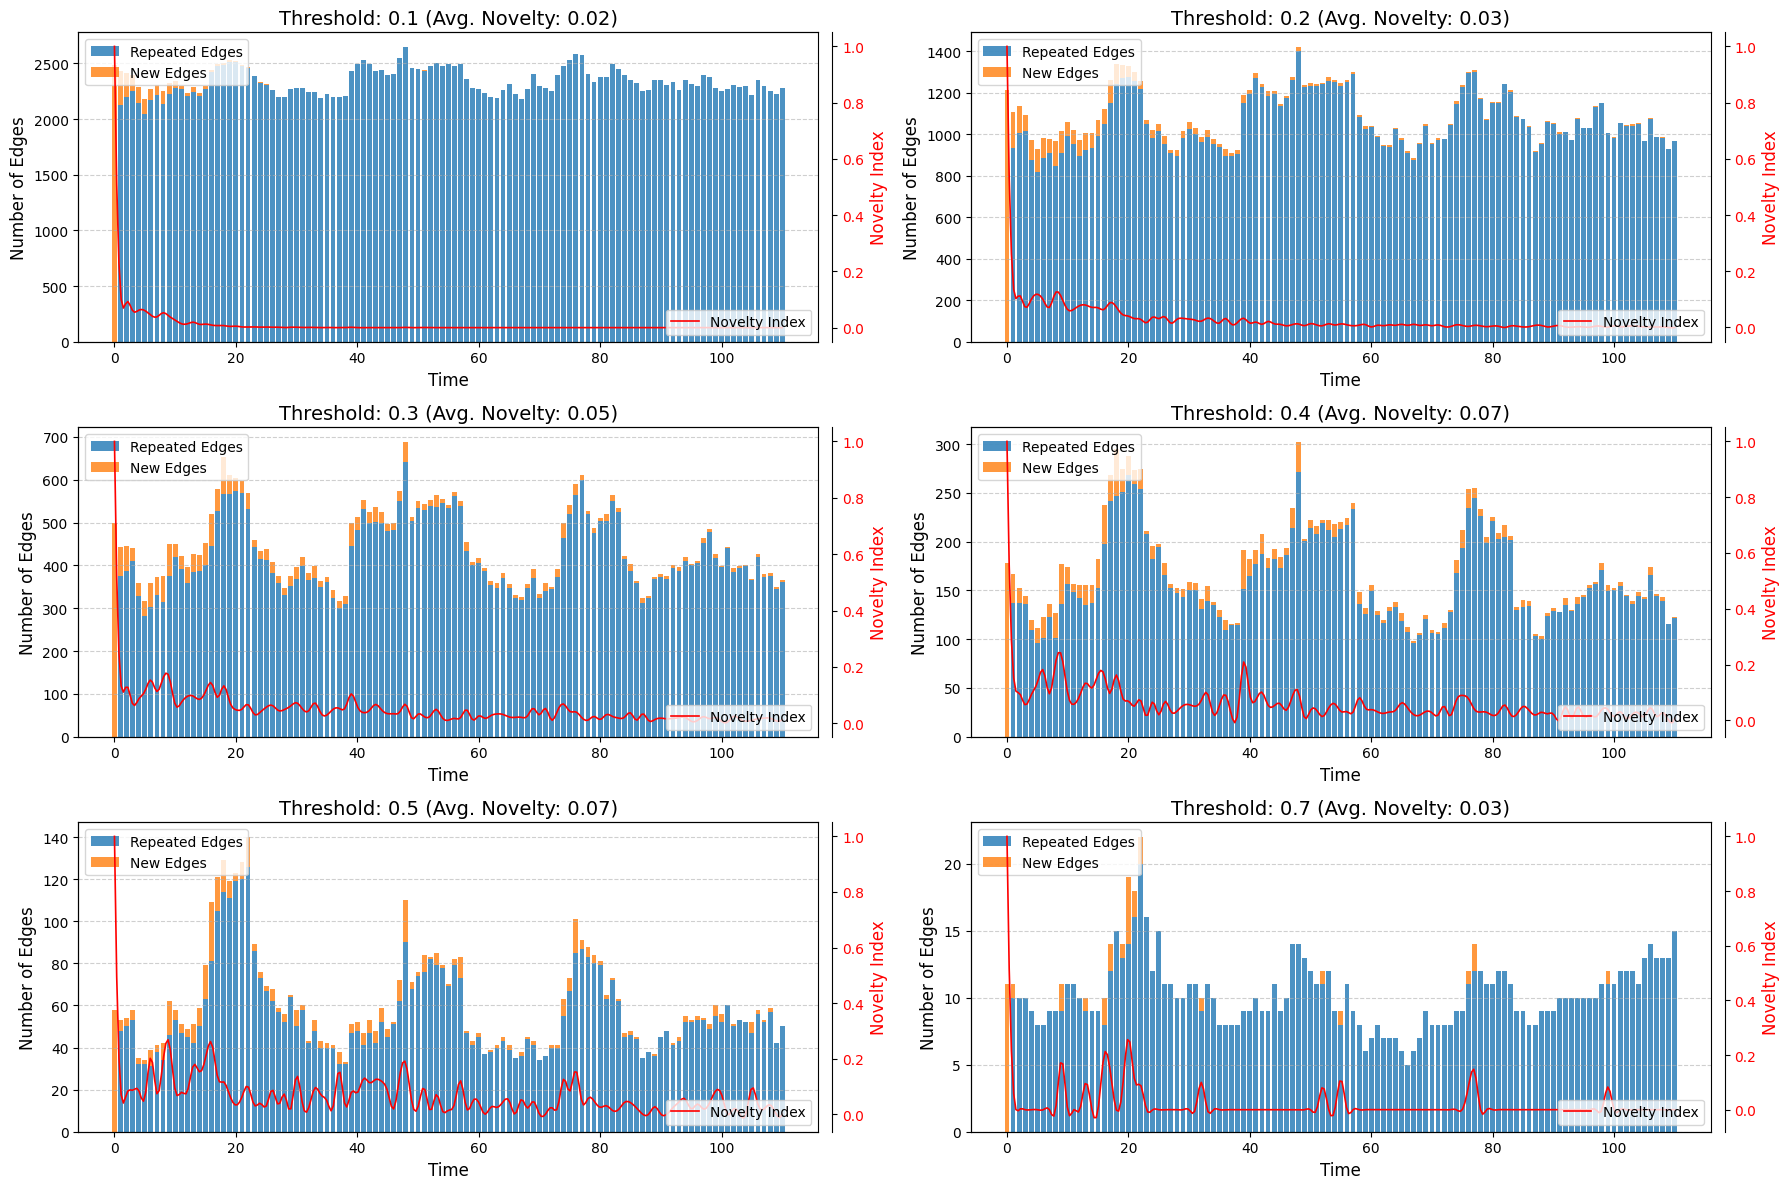

In [29]:
thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)
# change more in the beginning in threshold 0.2, more regione become connected

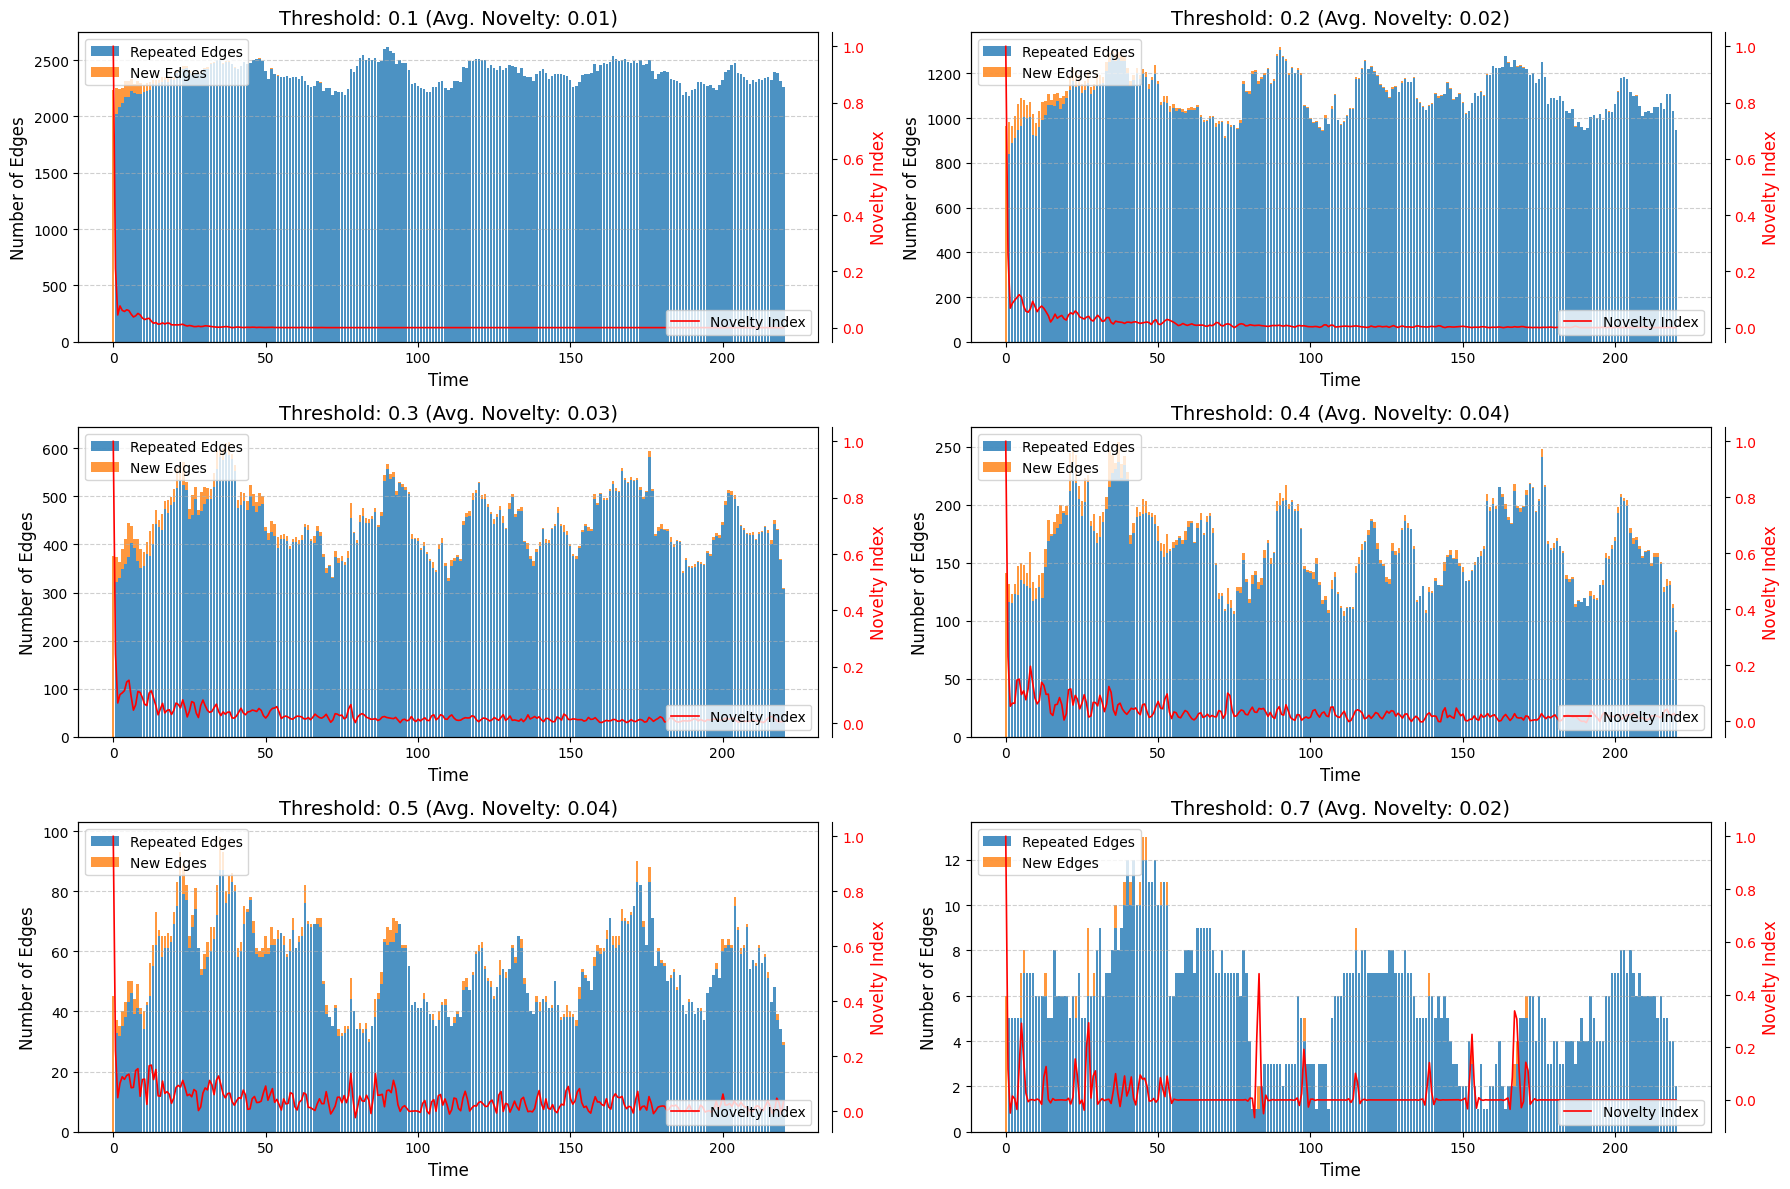

In [79]:
thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)
# change more in the beginning in threshold 0.2, more regione become connected

## Visualization

### Brain Atlas(Schaefer 2018)

[_add_readme_to_default_data_locations] Added README.md to data

[get_dataset_dir] Dataset created in data/schaefer_2018

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_100Parcels_17Networks_order.txt ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_100Parcels_17Networks_order_FSLMNI152_2mm
.nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

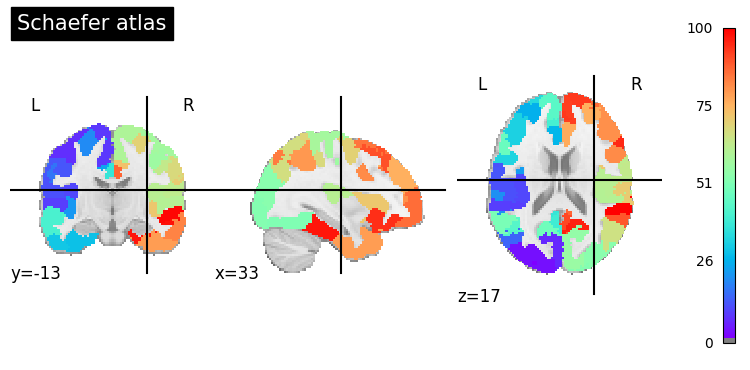

In [30]:
from nilearn import datasets, plotting

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=17, resolution_mm=2, data_dir='data')
atlas_map = atlas['maps']
roi_labels = atlas['labels']

# Plot the brain rois
plotting.plot_roi(atlas_map, title="Schaefer atlas", cmap = 'rainbow', alpha=1, draw_cross=True, colorbar=True, annotate=True)

In [46]:
idx = np.where(roi_labels == b"17Networks_LH_VisCent_ExStr_1")[0] + 1
idx

array([1])

In [43]:
np.where(roi_labels == b"17Networks_LH_VisCent_ExStr_1")

(array([0]),)

In [45]:
roi_labels[0]

np.bytes_(b'17Networks_LH_VisCent_ExStr_1')

(91, 109, 91)
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
(91, 109, 91)


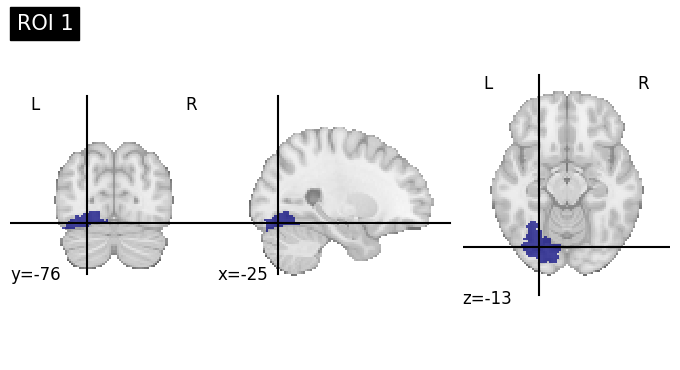

In [54]:
from nilearn import image

img = image.load_img('./data/schaefer_2018/Schaefer2018_100Parcels_17Networks_order_FSLMNI152_2mm.nii.gz')
# Print basic info
print(img.shape)        # 3D or 4D shape
print(img.affine)       # affine transformation matrix

# Convert to numpy array
data = img.get_fdata()
print(data.shape)       # same shape as img.shape

# Choose an ROI label (e.g., 60)
roi_label = 1

# Create a binary mask for this ROI
roi_mask = image.math_img("img == %d" % roi_label, img=img)

# Plot the ROI
plotting.plot_roi(roi_mask, title=f"ROI {roi_label}")
plotting.show()

[fetch_single_file] Downloading data from 
https://files.osf.io/v1/resources/4mw3a/providers/osfstorage/60b684b53a6df1021bd4df2d ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/Users/yiran/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz...

[uncompress_file] .. done.

(32492,) (32492,)


/var/folders/wl/7rv_syw512vc9pzdk76485k40000gn/T/ipykernel_99011/1937628789.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


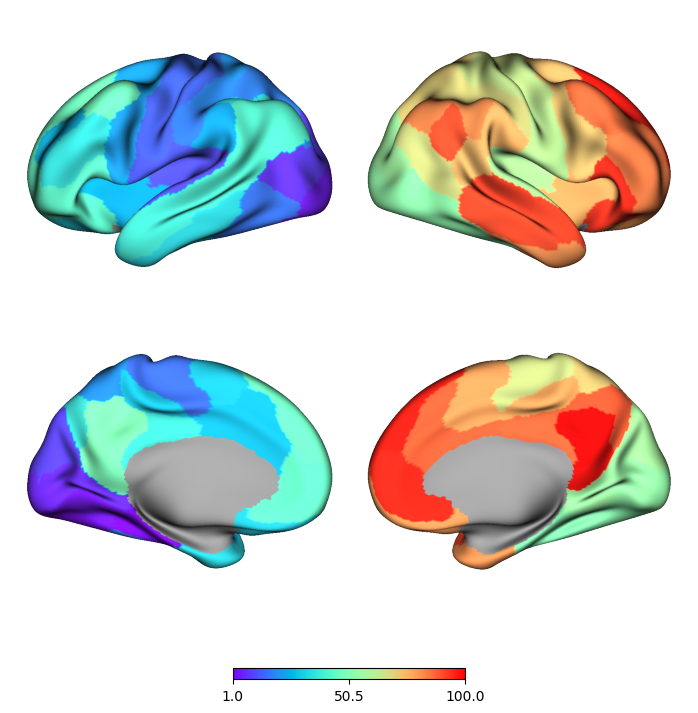

In [33]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

# visualize schaefer atlas into brain surface (each hemisphere contains 32492 voxels)
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']  #inflated, veryinflated, white, pial
# lh, rh = surfaces['veryinflated']  #inflated, veryinflated, white, pial
# lh, rh = surfaces['midthickness']  #inflated, veryinflated, white, pial
p = Plot(lh, rh, views=['lateral', 'medial'], size=(900, 800),  zoom=1.3, layout='grid')

# add schaefer parcellation
lh_parc, rh_parc = load_parcellation('schaefer',scale=100)
print(lh_parc.shape, rh_parc.shape)

p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap = 'rainbow', alpha=1, as_outline=False, cbar=True)

fig = p.build()
fig.show()

## cosine similarity

### weighted

In [298]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns

def cosine_sim_plot(graph_type):
    # Set Seaborn style for better aesthetics
    
    sns.set_style("whitegrid")

    cosine_similarities = []
    reference_time_step = 10

    # Iterate over time steps starting from time step 9 to num_windows_per_session - 1
    for t in range(reference_time_step - 1, len(graph_type) - 1):
        # Compute the cosine similarity between the adjacency matrix at time step t and the adjacency matrices of its past 10 time steps
        cosine_sim_values = []
        for i in range(reference_time_step):
            if np.sum(graph_type[t]) == 0 or np.sum(graph_type[t - i]) == 0:
                cosine_sim = 1.0  
            else:
                cosine_sim = cosine_similarity(graph_type[t], graph_type[t - i])
            cosine_sim_values.append(cosine_sim[0, 0])
        # print("t = ", cosine_sim_values)
        cosine_similarities.append(cosine_sim_values)

    # Compute the average similarity across all time points
    average_similarity = np.mean(cosine_similarities, axis=0)


    # Define a smooth color palette for better visualization
    colors = sns.color_palette("coolwarm", len(cosine_similarities))

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, (y_values, color) in enumerate(zip(cosine_similarities, colors)):
        x_values = range(0, -reference_time_step, -1)  # Adjust x-axis range
        plt.plot(x_values, y_values, linestyle='-', linewidth=1.5, color=color)  # Reduced linewidth

    # Plot the average similarity line in black
    plt.plot(x_values, average_similarity, linestyle='-', linewidth=2, color='black', label='Average Similarity')

    plt.xlabel('Past Time Steps', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.title('Temporal Dynamics of Cosine Similarity for weighted graph', fontsize=16)
    plt.ylim(0, 1)
    plt.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    plt.show()

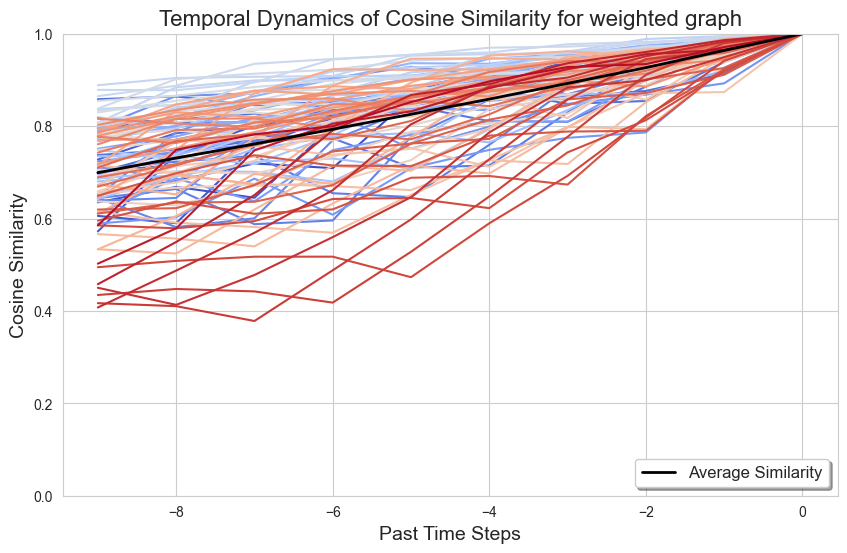

In [299]:
cosine_sim_plot(weighted_graph)

### binary

In [306]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns

def cosine_sim_binary_plot(graph_types, thresholds):
    # Set Seaborn style for better aesthetics
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (graph_type, threshold) in enumerate(zip(graph_types, thresholds)):
        row, col = divmod(idx, 2)
        ax = axes[row, col]
        
        cosine_similarities = []
        reference_time_step = 10

        # Iterate over time steps starting from time step 9 to num_windows_per_session - 1
        for t in range(reference_time_step - 1, len(graph_type)):
            cosine_sim_values = []
            for i in range(reference_time_step):
                cosine_sim = cosine_similarity(graph_type[t].flatten().reshape(1, -1), graph_type[t - i].flatten().reshape(1, -1))
                cosine_sim_values.append(cosine_sim[0, 0])

            cosine_similarities.append(cosine_sim_values)

        # Compute the average similarity across all time points
        average_similarity = np.mean(cosine_similarities, axis=0)

        # Define a smooth color palette for better visualization
        colors = sns.color_palette("coolwarm", len(cosine_similarities))

        # Plot each similarity trajectory
        for y_values, color in zip(cosine_similarities, colors):
            x_values = range(0, -reference_time_step, -1)
            ax.plot(x_values, y_values, linestyle='-', linewidth=1.2, color=color)  # Finer linewidth
        
        # Plot the average similarity line in black
        ax.plot(x_values, average_similarity, linestyle='-', linewidth=1.5, color='black', label='Average Similarity')
        
        ax.set_xlabel('Past Time Steps', fontsize=12)
        ax.set_ylabel('Cosine Similarity', fontsize=12)
        ax.set_title(f'Threshold: {threshold}', fontsize=14)
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='-', alpha=0.6)
        ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

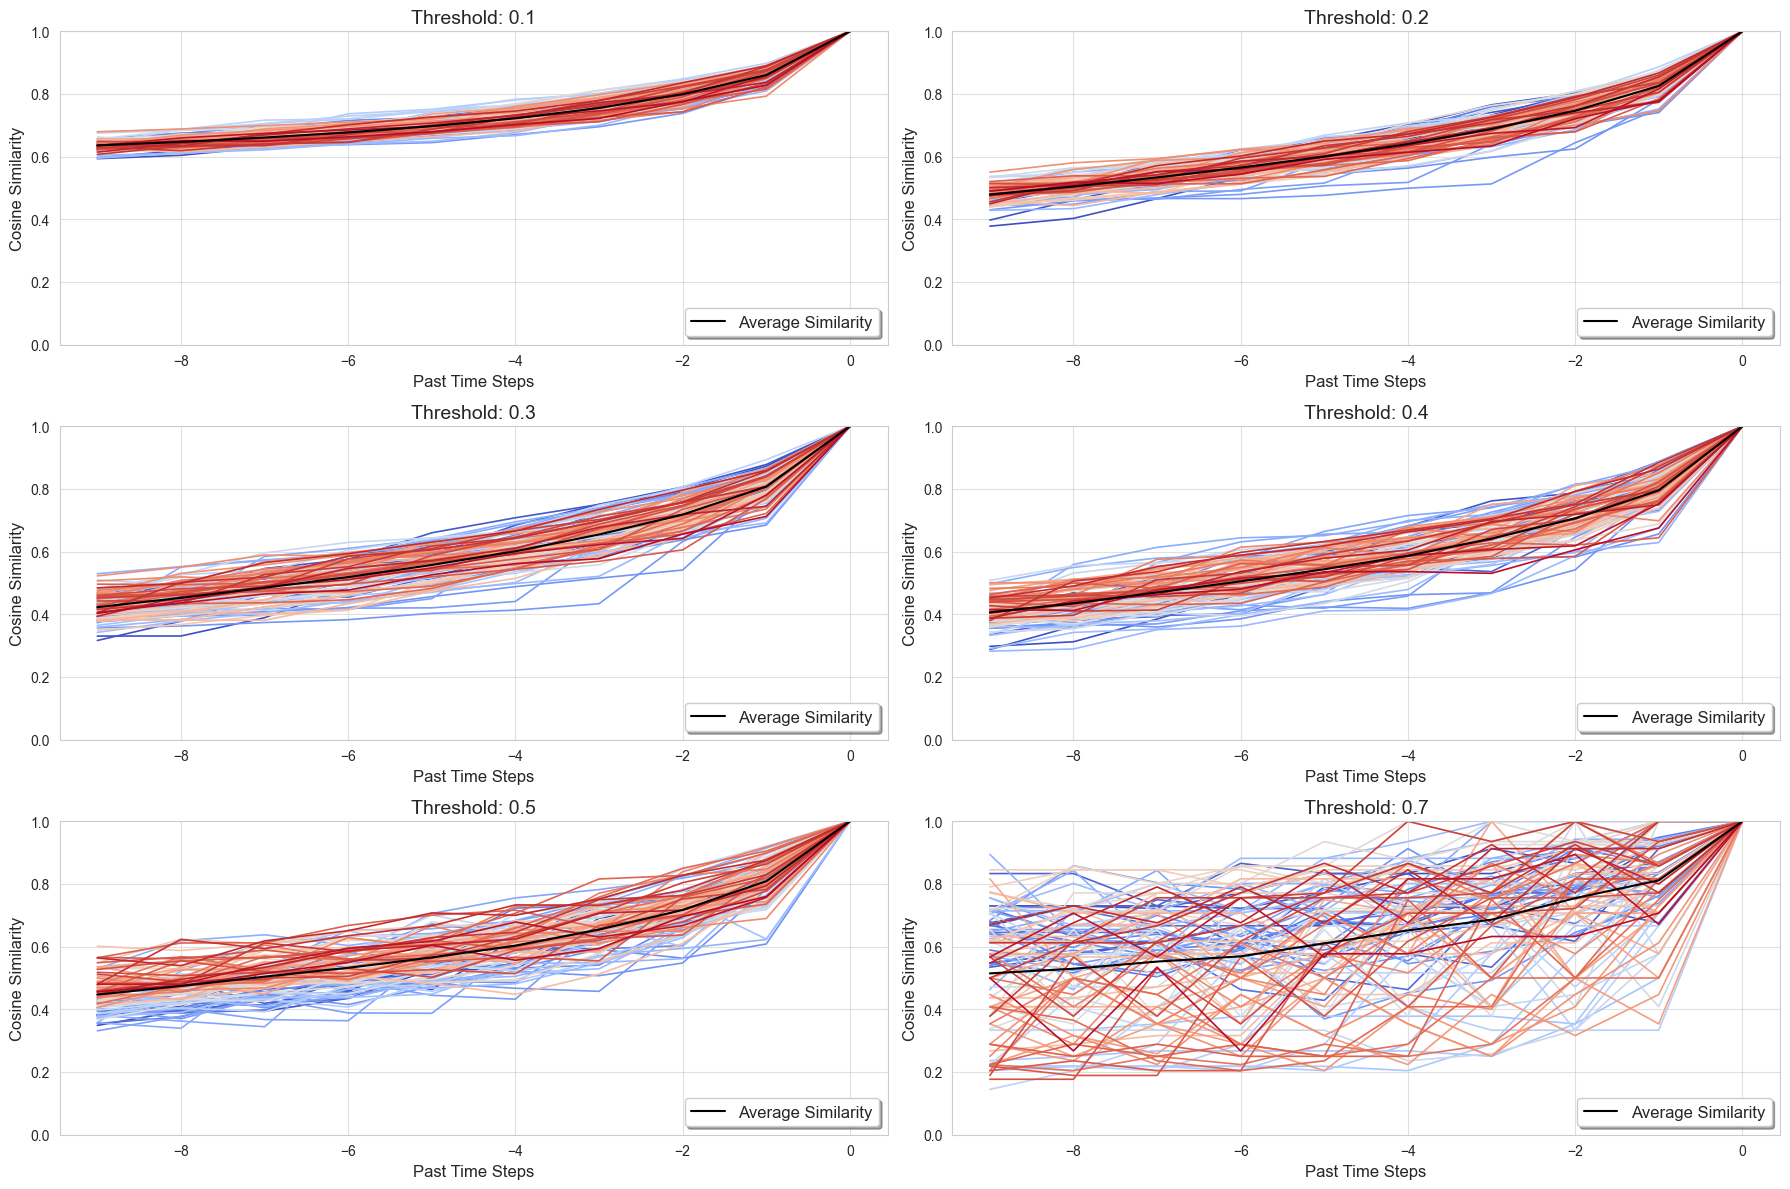

In [ ]:
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
cosine_sim_binary_plot(binary_temporal_graphs_list, thresh_list)

# prepare data

In [57]:
# Prepare data function
import itertools

def prepare_data_adaptive(dynfc_matrices, adaptive_lookbacks):
    dataset = {}
    hop_dict = {}
    scale_terms_dict = {}
    triplet_dict = {}
    scale_dict = {}

    num_windows, num_nodes, _ = dynfc_matrices.shape

    for i in range(len(adaptive_lookbacks)):
        lookback = adaptive_lookbacks[i]
        if i < lookback:
            continue  

        B = np.zeros((num_nodes, lookback + 1, num_nodes))
        for j in range(lookback + 1):
            B[:, j, :] = dynfc_matrices[i - lookback + j]
        dataset[i] = B

        hops = get_hops(dynfc_matrices[i], lookback)
        scale_terms = {
            h if h != -1 else max(hops.keys()) + 1:
            hops[h].sum(1) if h != -1 else hops[1].shape[0] - hops[h].sum(1)
            for h in hops
        }

        hop_dict[i] = hops
        scale_terms_dict[i] = scale_terms

        triplet, scale = to_triplets(sample_all_hops(hop_dict[i]), scale_terms_dict[i])
        triplet_dict[i] = triplet
        scale_dict[i] = scale

    return dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict


def prepare_data(dynfc_matrices, lookback):
    dataset = {}
    hop_dict = {}
    scale_terms_dict = {}
    triplet_dict = {}
    scale_dict = {}

    num_windows, num_nodes, _ = dynfc_matrices.shape

    for i in range(lookback, num_windows):
        B = np.zeros((num_nodes, lookback + 1, num_nodes))
        for j in range(lookback + 1):
            adj_matr = dynfc_matrices[i - lookback + j]
            B[:, j, :] = adj_matr
        dataset[i] = B

    for i in range(lookback, num_windows):
        hops = get_hops(dynfc_matrices[i], 2) #!!!!
        scale_terms = {h if h != -1 else max(hops.keys()) + 1:
                       hops[h].sum(1) if h != -1 else hops[1].shape[0] - hops[h].sum(1)
                       for h in hops}
    

        hop_dict[i] = hops
        scale_terms_dict[i] = scale_terms

        triplet, scale = to_triplets(sample_all_hops(hop_dict[i]), scale_terms_dict[i])
        triplet_dict[i] = triplet
        scale_dict[i] = scale

    return dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict

# Define function to sample last hop
def sample_last_hop(dynfc_matrices, nodes):
    num_windows, num_nodes, _ = dynfc_matrices.shape
    sampled = np.random.randint(0, num_nodes, len(nodes))
    for window_idx in range(num_windows):
        window_matrix = dynfc_matrices[window_idx]
        nnz = np.nonzero(window_matrix[nodes, sampled])[0]
        while len(nnz) != 0:
            new_sample = np.random.randint(0, num_nodes, len(nnz))
            sampled[nnz] = new_sample
            nnz = np.nonzero(window_matrix[nnz, new_sample])[0]
    return sampled

# Define function to sample all hops
def sample_all_hops(hops, nodes=None):
    N = hops[1].shape[0]
    if nodes is None:
        nodes = np.arange(N)
    sampled_nodes = []
    for node in nodes:
        node_samples = [node]
        for h in hops.keys():
            if h != -1:
                if len(hops[h]) == 0:
                    node_samples.append(-1)
                else:
                    node_samples.append(np.random.choice(hops[h][node]))
        node_samples.append(np.random.randint(0, N))
        sampled_nodes.append(node_samples)
    return np.array(sampled_nodes)

# Define function to get hops
def get_hops(dynfc_matrices, K=2):
    num_windows, num_nodes = dynfc_matrices.shape
    hops = {1: dynfc_matrices.copy(), -1: dynfc_matrices.copy()}
    np.fill_diagonal(hops[1], 0)
    for h in range(2, K + 1):
        next_hop = np.dot(hops[h - 1], dynfc_matrices)
        next_hop[next_hop > 0] = 1
        for prev_h in range(1, h):
            next_hop -= np.multiply(next_hop, hops[prev_h])
        np.fill_diagonal(next_hop, 0)
        hops[h] = next_hop
        hops[-1] += next_hop
    return hops

# Define function to convert to triplets
def to_triplets(sampled_nodes, scale_terms):
    triplets = []
    triplet_scale_terms = []
    for i, j in itertools.combinations(np.arange(1, sampled_nodes.shape[1]), 2):
        triplet = sampled_nodes[:, [0] + [i, j]]
        triplet = triplet[(triplet[:, 1] != -1) & (triplet[:, 2] != -1)]
        triplet = triplet[(triplet[:, 0] != triplet[:, 1]) & (triplet[:, 0] != triplet[:, 2])]
        triplets.append(triplet)
        triplet_scale_terms.append(scale_terms[i][triplet[:, 1]] * scale_terms[j][triplet[:, 2]])
    return np.row_stack(triplets), np.concatenate(triplet_scale_terms)


In [27]:
# Define hyperparameters
import torch


dim_out = 64
dim_in  = 92
dim_val = 256
dim_attn = 256
lr = 2.2307858381535968e-05
n_heads = 1
n_encoder_layers = 1
lookback = 2
epochs = 245
dropout=0.1766
weight_decay=1.466563344626497e-05

original_data = binary_temporal_graphs  # shape (111, 92, 92)
# padded_data = np.zeros((111, 96, 96), dtype=original_data.dtype)
# padded_data[:, :92, :92] = original_data

# Prepare data
dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict = prepare_data(original_data, lookback)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_size = int(0.7 * binary_temporal_graphs_len)  # 77 samples for training
val_size = int(0.2 * binary_temporal_graphs_len)  # 22 samples for validation
test_size = binary_temporal_graphs_len - train_size - val_size  # 12 samples for testing
train_val_gap_size = 0  # No gap needed

# Compute new indices
train_end = lookback + train_size
val_start = train_end
val_end = val_start + val_size
test_start = val_end
test_end = binary_temporal_graphs_len

# Define training, validation, and test datasets
train_data = {i: torch.tensor(dataset[i], dtype=torch.float32).to(device) for i in range(lookback, train_end)}
val_data = {i: torch.tensor(dataset[i], dtype=torch.float32).to(device) for i in range(val_start, val_end)}
test_data = {i: torch.tensor(dataset[i], dtype=torch.float32).to(device) for i in range(test_start, test_end)}

# Print confirmation
print(f"Training Data: {lookback} to {train_end}")
print(f"Validation Data: {val_start} to {val_end}")
print(f"Test Data: {test_start} to {test_end}")

Training Data: 2 to 79
Validation Data: 79 to 101
Test Data: 101 to 111


In [58]:
dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict = prepare_data_adaptive(original_data, adaptive_lookbacks)

In [59]:
len(dataset), len(hop_dict), len(scale_terms_dict), len(triplet_dict), len(scale_dict)

(106, 106, 106, 106, 106)

In [68]:
dataset[32].shape

(92, 5, 92)